### Mind the backend
This seminar was meant for taito-GPU cluster and __not the Everware__ nodes you used throughout the course.

- One can still run it on Everware node after changing data paths, but it will probably take longer without a GPU

In [1]:
import random
gpuid = random.randint(0,3)
import os
print "random GPU roll: ",gpuid
#os.environ["THEANO_FLAGS"]="device=gpu%i"%gpuid
os.environ["THEANO_FLAGS"]="device=gpu3"

random GPU roll:  3


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import theano
import theano.tensor as T
import lasagne

# Load the challenge data
* Currently we are using raw data features with no preprocessing in hope that NN figures that out
* One may try any feature engineering he wants

In [63]:
import pandas as pd
import itertools
data = pd.DataFrame.from_csv("/homeappl/home/austyuzh/data/train.csv",)
test = pd.DataFrame.from_csv("/homeappl/home/austyuzh/data/public_test.csv",)

high_level_features = ['m_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']

pts = ['jet4_pt', 'jet3_pt', 'jet2_pt', 'jet1_pt', 'lepton_pt', 'mem_pt']
etas = ['jet4_eta', 'jet3_eta', 'jet2_eta', 'jet1_eta', 'lepton_eta']
phis = ['jet4_phi', 'jet3_phi', 'jet2_phi', 'jet1_phi', 'lepton_phi', 'mem_phi']

# pt order jets
jet_pt = pts[:4]
jet_eta = etas[:4]
jet_phis = phis[:4]

idx = np.argsort(np.array(data[jet_pt]))
colidx = np.arange(data[jet_pt].shape[0])[:,np.newaxis]
data[jet_pt] = np.array(data[jet_pt])[colidx, idx]
data[jet_eta] = np.array(data[jet_eta])[colidx, idx]
data[jet_phis] = np.array(data[jet_phis])[colidx, idx]

idx = np.argsort(np.array(test[jet_pt]))
colidx = np.arange(test[jet_pt].shape[0])[:,np.newaxis]
test[jet_pt] = np.array(test[jet_pt])[colidx, idx]
test[jet_eta] = np.array(test[jet_eta])[colidx, idx]
test[jet_phis] = np.array(test[jet_phis])[colidx, idx]

name = 'pt_tot'
data[name] = data[pts].sum(axis=1)
test[name] = test[pts].sum(axis=1)

name = 'm_tot'
data[name] = data[high_level_features].sum(axis=1)
test[name] = test[high_level_features].sum(axis=1)

for a, b in itertools.combinations(np.arange(5), 2):
    name = 'dR(%s, %s)' % (etas[a][:-4], etas[b][:-4])
    data[name] = np.sqrt((data[etas[a]] - data[etas[b]])**2 + (data[phis[a]] - data[phis[a]])**2)
    test[name] = np.sqrt((test[etas[a]] - test[etas[b]])**2 + (test[phis[a]] - test[phis[a]])**2)

for df in [test, data]:
    df['m_bb/m_wbb'] = df['m_bb']/df['m_wbb']
    df['m_wwbb/m_wbb'] = df['m_wwbb']/df['m_wbb']
    df['m_bb/m_lv'] = df['m_bb']/df['m_lv']
    df['m_bb/m_tot'] = df['m_bb']/df['m_tot']
    
n_features = df.shape[1]-1

In [ ]:
# rotate etas 
np.random.random(shape=(data.shape[0], len(etas)))

In [64]:
print(data.shape)
y = data['target'].values==1
X = data[data.columns[1:]].values.astype(theano.config.floatX)

(10000000, 45)


In [7]:
from sklearn.cross_validation import train_test_split
#X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=1337)

# NN architecture
 * We take a simple NN with __3 hidden layers__:
     * Layers must contain 500 hidden units each
     * Layers must use __tanh__ nonlinearity
 * structure can be farther optimized, so feel free to experiment __after__ you got it working

In [78]:
input_X = T.matrix('input X')
target_Y = T.ivector('target Y')

In [79]:
from lasagne.layers import InputLayer,DenseLayer,batch_norm,dropout

In [80]:
l_in = InputLayer([None, n_features],input_X,'input layer')

n_hid = 1000
nonlin = lasagne.nonlinearities.elu

nl_in = batch_norm(l_in, name='batchnorm_input_layer')

ol_0 = DenseLayer(nl_in,
                num_units=n_hid,
                name='dense0',
                nonlinearity=nonlin)

nl_0 = batch_norm(ol_0, name='batchnorm_l_0')
l_0 = dropout(nl_0, p=0.2, name='dropout_l_0')

ol_1 = DenseLayer(l_0,
                num_units=n_hid,
                name='dense1',
                nonlinearity=nonlin)

l_1 = batch_norm(ol_1, name='batchnorm_l_1')


ol_2 = DenseLayer(l_1,
                num_units=n_hid,
                name='dense2',
                nonlinearity=nonlin)

l_2 = batch_norm(ol_2, name='batchnorm_l_2')

ol_3 = DenseLayer(l_2,
                num_units=n_hid,
                name='dense3',
                nonlinearity=nonlin)

l_3 = batch_norm(ol_3, name='batchnorm_l_3')

ol_4 = DenseLayer(l_3,
                num_units=n_hid,
                name='dense4',
                nonlinearity=nonlin)

l_4 = batch_norm(ol_4, name='batchnorm_l_4')

nn = DenseLayer(l_4,num_units=2,
                name='dense out',
                nonlinearity=lasagne.nonlinearities.softmax)

In [81]:
weights = lasagne.layers.get_all_params(nn,trainable=True)
weights

[batchnorm_input_layer.beta,
 batchnorm_input_layer.gamma,
 dense0.W,
 batchnorm_l_0.beta,
 batchnorm_l_0.gamma,
 dense1.W,
 batchnorm_l_1.beta,
 batchnorm_l_1.gamma,
 dense2.W,
 batchnorm_l_2.beta,
 batchnorm_l_2.gamma,
 dense3.W,
 batchnorm_l_3.beta,
 batchnorm_l_3.gamma,
 dense4.W,
 batchnorm_l_4.beta,
 batchnorm_l_4.gamma,
 dense out.W,
 dense out.b]

# weight updates

In [82]:
nn_out = lasagne.layers.get_output(nn)
loss = lasagne.objectives.categorical_crossentropy(nn_out, target_Y).mean()

In [83]:
updates =lasagne.updates.adadelta(loss,weights)
train_fun = theano.function([input_X,target_Y],[loss,nn_out[:,1]],updates=updates)

# deterministic predict

In [84]:
det_nn_out = lasagne.layers.get_output(nn,deterministic=True)
det_loss = lasagne.objectives.categorical_crossentropy(det_nn_out,target_Y).mean()
val_fun = theano.function([input_X,target_Y],[det_loss,nn_out[:,1]])
eval_nn = theano.function([input_X], [det_nn_out[:,1]])

# training loop
* Almost identical to the original loop from previous seminar
* The only difference is that now we keep track of NN performance across iterations

In [15]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [90]:
train_auc_curve = []
train_acc_curve = []
val_auc_curve = []
val_acc_curve = []

num_epochs = 50
batch_size=15000

import time
from sklearn.metrics import roc_auc_score,accuracy_score

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:

    start_time = time.time()
    
    train_err = 0
    Ypred_batches = []
    Ytrue_batches = []
    train_batches = 0
    
    for batch in iterate_minibatches(X, y, batch_size, shuffle=True):
        inputs, targets = batch
        err, y_pred = train_fun(inputs, targets)
        
        Ypred_batches.append(y_pred)
        Ytrue_batches.append(targets)
        
        train_err += err
        train_batches += 1
    
    Ypred_train = np.concatenate(Ypred_batches)
    Ytrue_train = np.concatenate(Ytrue_batches)
    train_acc = accuracy_score(Ytrue_train, Ypred_train>0.5)
    train_auc = roc_auc_score(Ytrue_train, Ypred_train)
    
    train_acc_curve.append(train_acc)
    train_auc_curve.append(train_auc)


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  training accuracy:\t\t{:.2f} %".format(
        train_acc * 100))
    print("  training AUCscore:\t\t{:.2f} %".format(
        train_auc * 100))

    
    


Epoch 1 of 50 took 315.907s
  training loss:		0.475455
  training accuracy:		76.69 %
  training AUCscore:		85.07 %
Epoch 2 of 50 took 309.637s
  training loss:		0.475276
  training accuracy:		76.69 %
  training AUCscore:		85.08 %
Epoch 3 of 50 took 308.129s
  training loss:		0.475082
  training accuracy:		76.70 %
  training AUCscore:		85.09 %
Epoch 4 of 50 took 315.047s
  training loss:		0.474955
  training accuracy:		76.72 %
  training AUCscore:		85.10 %
Epoch 5 of 50 took 315.392s
  training loss:		0.474688
  training accuracy:		76.72 %
  training AUCscore:		85.12 %
Epoch 6 of 50 took 314.627s
  training loss:		0.474541
  training accuracy:		76.75 %
  training AUCscore:		85.13 %
Epoch 7 of 50 took 311.195s
  training loss:		0.474367
  training accuracy:		76.76 %
  training AUCscore:		85.14 %
Epoch 8 of 50 took 311.701s
  training loss:		0.474353
  training accuracy:		76.75 %
  training AUCscore:		85.15 %
Epoch 9 of 50 took 309.440s
  training loss:		0.474006
  training accuracy:		76.

KeyboardInterrupt: 

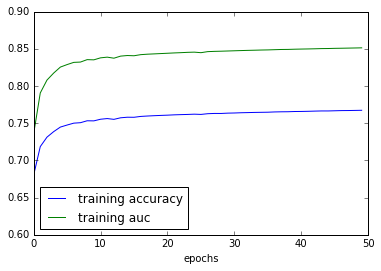

In [76]:
plt.plot(train_acc_curve,label='training accuracy')
plt.plot(train_auc_curve,label='training auc')
plt.xlabel("epochs")
plt.legend(loc='best')
plt.ylim(0.6,0.9);

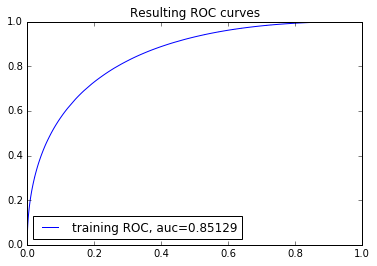

In [77]:
from sklearn.metrics import roc_curve
plt.title('Resulting ROC curves')

fpr,tpr,_ = roc_curve(Ytrue_train,Ypred_train)
plt.plot(fpr,tpr,label='training ROC, auc=%.5f'%(train_auc))

plt.legend(loc='best')


Index([u'lepton_pt', u'lepton_eta', u'lepton_phi', u'mem_pt', u'mem_phi',
       u'jet1_pt', u'jet1_eta', u'jet1_phi', u'jet1_btag', u'jet2_pt',
       u'jet2_eta', u'jet2_phi', u'jet2_btag', u'jet3_pt', u'jet3_eta',
       u'jet3_phi', u'jet3_btag', u'jet4_pt', u'jet4_eta', u'jet4_phi',
       u'jet4_btag', u'm_jj', u'm_jjj', u'm_lv', u'm_jlv', u'm_bb', u'm_wbb',
       u'm_wwbb'],
      dtype='object')


array([[  5.88143539e+01,  -1.22319949e+00,   1.29071748e+00, ...,
          9.57374344e+01,   3.72835388e+02,   4.69654236e+02],
       [  2.13907814e+01,  -4.68276858e-01,  -1.37140429e+00, ...,
          1.95910385e+02,   3.10480103e+02,   4.31597137e+02],
       [  5.85702171e+01,   1.44309211e+00,   1.05191082e-01, ...,
          3.51328644e+02,   6.38053040e+02,   7.90960815e+02],
       ..., 
       [  7.40437012e+01,   1.87849438e+00,  -1.93299925e+00, ...,
          1.35753372e+02,   3.01967651e+02,   4.12872284e+02],
       [  6.61716843e+01,  -4.74488467e-01,  -9.88960624e-01, ...,
          8.23654480e+01,   6.89026123e+02,   9.28406311e+02],
       [  3.75219002e+01,  -1.21568963e-01,   2.39158845e+00, ...,
          1.39968231e+02,   2.65002258e+02,   3.61302765e+02]], dtype=float32)

In [91]:
#df[df.columns[1:]].values.astype(theano.config.floatX)
kaggle_proba = np.array(eval_nn(test.values.astype(theano.config.floatX)))
kaggle_proba.shape = (kaggle_proba.shape[1],)
kaggle_ids = np.arange(kaggle_proba.shape[0])+1

from IPython.display import FileLink
def create_solution(ids, proba, filename='baseline.csv'):
    """saves predictions to file and provides a link for downloading """
    pd.DataFrame({'event_id': ids, 'prediction': proba}).to_csv('{}'.format(filename), index=False)
    return FileLink('{}'.format(filename))
    
create_solution(kaggle_ids, kaggle_proba, filename='nn10m5.csv')

/homeappl/home/trng52/mlhep2016/day_6/nn10m5.csv

## Task 1:
Add batch normalization after each hidden layer. See if new network does better that the old one.

To add Batch Normalization, one can use batch_norm:

```
normalized_layer = lasagne.layers.batch_norm(previous_layer)
```

For simplicity, one can implement batch-normalized NN in a new notebook by 
clicking __File__ -> __Make a copy__ in the jupyter notebook top bar. Do not forget to rename the copy.


Alternatively, one can just copy-paste code or start editing


__Bonus task 1.1__:
 - See if batch-normalizing input does you any good.
 - Which operation is this ~equivalent to in terms of Scikit-Learn?
 
 
__ After you made it through batch_normalization, scroll to the notebook bottom for the second assignment__

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

#### Assuming, you made it through the batch-normalization assignment.

__Task2__

If you have seen the batch-normalized NN learning curves, you probably have noticed that the validation curves first ascended to a peak and than started to descend while the training score still increase. That's some __overfitting__ happening right in front of you!

Your second task, and also a reasonable step towards improving your kaggle ensemble, is to get rid of that overfitting by the tools you know already:

- __Early stopping__: stop training when validation score starts decreasing
- __Dropout__: force nn to learn redundant representations using [lasagne.layers.DropoutLayer](http://lasagne.readthedocs.io/en/latest/modules/layers/noise.html) (syntax like batch_norm)
- __L2 or L1 regularization__: plain old weight penalty still works here. Can be implemented using [lasagne.regularization](http://lasagne.readthedocs.io/en/latest/modules/regularization.html)
- __Distortion__: add random (e.g. gaussian) noize to the input data to virtually increase dataset size. 
   * Can be done via [gaussian noise layer](http://lasagne.readthedocs.io/en/latest/modules/layers/noise.html#lasagne.layers.GaussianNoiseLayer) or manually
   
   
A friendly advice:
 - You are not restricted to a single approach, however we recommend slow and methodic changes against mixing everything in random proportions right away.
 - If a method is more mathematically sound or cool than others, it doesn't mean it's bound to score better in competition.
   
Again, the recommended approach is to copy a notebook and solve the task in the copied version, however you may pick ane approach at your own doom.